# ИССЛЕДОВАТЕЛЬСКИЙ КОД ДЛЯ ПОСТРОЕНИЯ ТРЕНДОВ ФЕС ПО ДАННЫМ СРР И ЭРР ДЛЯ БАЖЕНОВСКОЙ СВИТЫ

## 1. ЗАГРУЗКА БИБЛИОТЕК

In [1]:
#БАЗОВЫЕ БИБЛИОТЕКИ
import pandas as pd
import numpy as np
import glob
import os

#CИСТЕМНЫЕ БИБЛИОТЕКИ
import sys
import glob

#ГРАФИЧЕСКИЕ БИБЛИОТЕКИ
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#БИБЛИОТЕКА ДЛЯ РАБОТЫ С ЛАС-ФАЙЛАМИ
import lasio

#БИБЛИОТЕКА МАШИННОГО ОБУЧЕНИЯ
import sklearn

#БИБЛИОТЕКИ И МОДУЛИ СТАТИСТИЧЕСКИХ ВЫЧИСЛЕНИЙ
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, classification_report, accuracy_score
from sklearn.decomposition import PCA
from scipy.stats import pearsonr


#БИБЛИОТЕКИ И МОДУЛИ ВЫБОРА МОДЕЛЕЙ
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV

# БИБЛИОТЕКИ ДЛЯ ПРОГНОЗА ДИСКРЕТНЫХ СВОЙСТВ
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


# БИБЛИОТЕКИ И МОДУЛИ ЛИНЕЙНЫХ МОДЕЛЕЙ
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

# БИБЛИОТЕКИ ОБРАБОТКИ СИГНАЛОВ
from scipy.signal import medfilt

import warnings
warnings.filterwarnings('ignore')

## 2. ЗАГРУЗКА СКВАЖИННЫХ ДАННЫХ (РИГИС И ПУМ), СОЗДАНИЕ ЕДИНОЙ DATAFRAME, ПРИСВОЕНИЕ СТРАТИГРАФИИ, ФИЛЬТРАЦИЯ В ИНТЕРВАЛЕ БС

In [2]:
# Загрузка отдельных las-файлов и стратиграфии

strat_path = r'C:\Users\user\Documents\ML Пальян\Входные данные'
os.chdir(strat_path)
strat = pd.read_csv('Stratigraphy v2.txt', sep = '\t')

las_path = r'C:\Users\user\Documents\ML Пальян\Входные данные\Каротаж'
os.chdir(las_path)
wells = [f for f in glob.glob('*.las')]

# Функция для создания словаря со скважинными отбивками для каждой скважины
def get_tops_for_well(well, tops):
    tops_well_filtered = tops[(tops['Well']) == well]
    tops_well_filtered.reset_index(inplace = True)
    surfaces = ['UK0', 'IV', 'III', 'II', 'I', 'UK1', 'UK2-3']
    tops_dict = {surf: np.nan for surf in surfaces}
    
    for i in range(0, tops_well_filtered.shape[0]):
        tops_dict[tops_well_filtered.loc[i,'Surface']] = tops_well_filtered.loc[i,'MD']
    
    return tops_dict


###################################################################################################################


# Функция для кривой стратиграфии в скаждой скважине
def zonelog (zonelog_list, tops_dict, MD):
    
    if MD >= tops_dict['UK0'] and MD < tops_dict['IV']:
        zonelog_list.append('V')
    elif MD >= tops_dict['IV'] and MD < tops_dict['III']:
        zonelog_list.append('IV')
    elif MD >= tops_dict['III'] and MD < tops_dict['II']:
        zonelog_list.append('III')
    elif MD >= tops_dict['II'] and MD < tops_dict['I']:
        zonelog_list.append('II')
    elif MD >= tops_dict['I'] and MD < tops_dict['UK1']:
        zonelog_list.append('I')
    elif MD >= tops_dict['UK1'] and MD < tops_dict['UK2-3']:
        zonelog_list.append('UK1')
    else:
        zonelog_list.append('N/A')
        
    return zonelog_list

###################################################################################################################


# Объединение всех las-файлов в единую dataframe
counter = 0
for well in wells:
    counter = counter + 1
    well_name = well.split('.')[0]
    print('********** WELL PROCESSED:{w} **********'.format(w = well_name))
    tops_dict = get_tops_for_well(well_name, strat)
    
    if counter == 1:
        las = lasio.read(well)
        df = las.df()
        well_name_to_df = [well_name for i in range(0,df.shape[0])]
        df[['WELL']] = well_name_to_df
        MD = df.index.values.tolist()
        
        zone = []
        for i in MD:
            zonelog_list = zonelog(zone, tops_dict, i)
        
        df[['ZONE']] = zone
            
    else:
        las2 = lasio.read(well)
        df2 = las2.df()
        well_name_to_df = [well_name for i in range(0,df2.shape[0])]
        df2[['WELL']] = well_name_to_df
        MD = df2.index.values.tolist()
        
        zone = []
        for i in MD:
            zonelog_list = zonelog(zone, tops_dict, i)
        
        df2[['ZONE']] = zone
        df = pd.concat([df, df2])
        
        
###################################################################################################################


# Убираем лишние кривые ГИС, оставляем нужные кривые по РИГИС из ПУМ
df_clean = df[['AI_MOD', 
              'BI_RR_MOD_INTERP_BAZH_CCE',
              'BITUMEN', 
              'CBW', 
              'CLAY', 
              'CQ_FLAG',
              'E_MOD', 
              'EQ_FLAG', 
              'G_MOD',
              'GR', 
              'K_MOD', 
              'KEROGEN', 
              'LITHOLOGY', 
              'M_MOD', 
              'MATRIX', 
              'OIL', 
              'PERM', 
              'PHID', 
              'PHIE',
              'PHIT', 
              'PR_MOD', 
              'PYRITE', 
              'RCEQ_FLAG',
              'RHOB_MOD', 
              'RQ_FLAG', 
              'RT',
              'SH_FLAG', 
              'SHC', 
              'SI_MOD', 
              'SW', 
              'TNPH', 
              'TOC',
              'VP_MOD', 
              'VPVS_MOD',
              'VS_MOD', 
              'VSH', 
              'WATER', 
              'WELL',
              'ZONE']]


###################################################################################################################

# Заменяем индексирование DATAFRAME по строкам с MD на целые значения 0,1,2.... MD добавляем в качестве отдельного столбца. 
# Данная DF нужна будет чтобы в процессе фильтарции Гауссовым фильтром, чтобы избежать краевых эффектом на кровле и подошве бажена

MD = df_clean.index.values.tolist()
df_clean['MD'] = MD
df_clean.reset_index(inplace = True, drop = True)

###################################################################################################################

# Фильтруем итоговую dataframe в интервале баженовской свиты
df_clean_b = df_clean[(df_clean['ZONE'] != 'N/A')]
print('=============== DATASET SIZE: {s1} POINTS BY {s2} VECTORS ==============='.format(s1 = df_clean_b.shape[0], s2 = df_clean_b.shape[1]))

###################################################################################################################

# Экспортируем итоговую dataframe в csv-файл
output_path = r'C:\Users\user\Documents\ML Пальян'
os.chdir(output_path)
df_clean_b.to_csv('Palyan_ML_clean_df.csv')

********** WELL PROCESSED:130_p **********
********** WELL PROCESSED:134_p **********
********** WELL PROCESSED:138_p **********
********** WELL PROCESSED:157_p **********
********** WELL PROCESSED:158_p **********
********** WELL PROCESSED:203_p **********
********** WELL PROCESSED:211_p **********
********** WELL PROCESSED:22R **********
********** WELL PROCESSED:238_p **********
********** WELL PROCESSED:29R **********
********** WELL PROCESSED:32R **********
********** WELL PROCESSED:35R **********
********** WELL PROCESSED:37R **********
********** WELL PROCESSED:414R **********
********** WELL PROCESSED:42R **********
********** WELL PROCESSED:441R **********
********** WELL PROCESSED:457R **********
********** WELL PROCESSED:463R **********
********** WELL PROCESSED:600R **********
********** WELL PROCESSED:601R **********
********** WELL PROCESSED:603R **********
********** WELL PROCESSED:611R **********
********** WELL PROCESSED:9234B **********
********** WELL PROCESSED:9426 

## 3. ФИЛЬТРАЦИЯ УПРУГИХ СВОЙСТВ И СОПРОТИВЛЕНИЙ ПО СКВАЖИННЫМ ДАННЫМ ГАУССОВЫМ ФИЛЬТРОМ С ЗАДАННЫМ ОКНОМ

In [21]:
# Smoothing window width in meteres
smoothing_window = 30

df_clean_smooth = df_clean.copy()
data = ['AI_MOD','SI_MOD', 'VPVS_MOD','PR_MOD','RHOB_MOD','RT']
for i in data:
    #df_clean_lith_smooth[i] = medfilt(df_clean_lith_smooth[i], 25)
    df_clean_smooth[[i]] = df_clean_smooth[[i]].rolling(smoothing_window*10, win_type = 'gaussian', center = True).mean(std = smoothing_window/6)


## 4. ЗАДАНИЕ ФУНКЦИИ И АНАЛИЗ КАЧЕСТВА МОДЕЛЕЙ С ИСПОЛЬЗОВАНИЕМ МНОГОМЕРНОЙ ЛИНЕЙНОЙ РЕГРЕСИИ

In [4]:
def linear_regression(df_in, features, target, fold, zone, blind_test_wells, unit_tick):
    # Provide features list, for example ['AI', 'VPVS', 'SI']
    # Target as curve name - for example 'PHI'
    # Unit tick - increment of units for plotting
    # Zoneы as a list
    # Blind test wells as a list
    
    # Создаем список столбцов для дальнейшего использования, который включает набо предикторов, целевую переменную, а также дополнительно скважину и зону.
    extended_features = features + target
    extended_features.extend(['WELL', 'ZONE'])
    df_b1_set = df_in[extended_features]
    
    # Убираем из обучивающей базы данных скважины для слепого теста
    df_b1_well = df_b1_set[(~df_b1_set['WELL'].isin(blind_test_wells))]
    
    # Оставляем в обучивающей базе данных скважины для конкретной зоны
    df_b1 = df_b1_well[(df_b1_well['ZONE'].isin(zone))]
    
    # Убираем из базы данных неопределенные значения
    df_b1.dropna(axis = 0, inplace = True)
    
    # Задаем данные для обучения многомерной линейной модели, создаем объект линейной модели и рассчитываем параметры модели с использованием кросс-валидации
    X_train = df_b1[features]
    Z_train = df_b1[target]
    lm = LinearRegression()
    scores = cross_validate(lm, X_train, Z_train, cv=fold, scoring='r2', return_train_score=True, return_estimator=True)
    
    # Полученные по кросс-валидации параметры модели осредняем и получаем итоговую модель (Bagging)
    numbers = list(range(1,len(features)+1))
    col = list(map(lambda i: 'Var' + str(i), numbers))
    b0 = []
    b1 = []
    
    for i in range(0,fold):
        b0.append(scores['estimator'][i].intercept_)
        b1.append(scores['estimator'][i].coef_[0])
        
    df_intercept =  pd.DataFrame(data = b0, columns = ['b0'])
    df_coeff = pd.DataFrame(data = b1, columns = col)
    b0_fin = df_intercept['b0'].mean()
    
    b1_fin = []
    for i in range(0,len(features)):
        name = 'Var' + str(i+1)
        b1_fin.append(df_coeff[name].mean())
        b1_fin_np = np.asarray(b1_fin).reshape(-1,1)

   
    # Начинаем контроль качества модели. Оставляем в тестовой выборке скважины для слепого теста
    df_b2_well = df_b1_set[(df_b1_set['WELL'].isin(blind_test_wells))]
    
    # Оставляем в базе данных для тестирования данные для конкретной зоны
    df_b2 = df_b2_well[(df_b2_well['ZONE'].isin(zone))]
    
    # Убираем из базы данных неопределенные значения
    df_b2.dropna(axis = 0, inplace = True)
    
    X_test = df_b2[features]
    Z_test = df_b2[target]
    
    # Рассчитываем прогнозное значение свойства по модели
    Z_hat = np.matmul(X_test.to_numpy(), b1_fin_np).flatten() + b0_fin
    Z_test_e = Z_test[target[0]].to_numpy()
    
    
    # Рассчитывем коэффициенты корреляции и среднюю квадратическую ошибку
    R2, P = pearsonr(Z_hat, Z_test_e)
    MSE = mean_squared_error(Z_hat, Z_test_e)
    
    # Строим график Y_истинное - Y_предсказанное
    fig1 = plt.figure(figsize = (10.0,10.0))
    visual_min = round(Z_test_e.min(),2)
    visual_max = round(Z_test_e.max(),2)
    sns.set(font="Arial")
    equals = np.linspace(visual_min, visual_max, int((visual_max - visual_min)/unit_tick))
    ax1 = sns.regplot(x = Z_test_e, y = Z_hat, fit_reg=False, color = 'red', scatter_kws={'s':40})
    ax1 = sns.lineplot(x = equals, y = equals)
    ax1.set(xlabel = 'Значения по тестовой выборке', ylabel = 'Предсказанные значения', xlim = (visual_min, visual_max), ylim = (visual_min, visual_max))
    ax1.set(xticks = (np.linspace(visual_min,visual_max, int((visual_max - visual_min)/unit_tick+1))), 
            yticks = np.linspace(visual_min,visual_max, int((visual_max - visual_min)/unit_tick+1))) 
    
    ax1.grid(b=True, which='major')
    
    
    # Строим график распределения ошибок
    fig2 = plt.figure(figsize = (10.0,10.0))
    ax2 = sns.residplot(Z_test,Z_hat)
    ax2.set(xlabel = 'Фактические - предсказанные значения')
    
    
    # Строим гистограммы распределения истинных значений и предсказанного значения свойств 
    fig3 = plt.figure(figsize = (10.0,10.0))
    ax3 = sns.distplot(Z_test_e, hist=False)
    ax3 = sns.distplot(Z_hat, hist=False)
    ax3.legend(['Фактические значения по тестовой выборке', 'Модель'])
    ax3.set(xlabel = target[0])
    ax3.set(xticks = (np.linspace(visual_min,visual_max, int((visual_max - visual_min)/unit_tick+1))))
    
    return fig1, fig2, fig3, round(Z_hat.min(),3), round(Z_test_e.min(),3), round(Z_hat.max(),3), round(Z_test_e.max(),3), round(R2,3), P, MSE, round(len(Z_test_e),3)

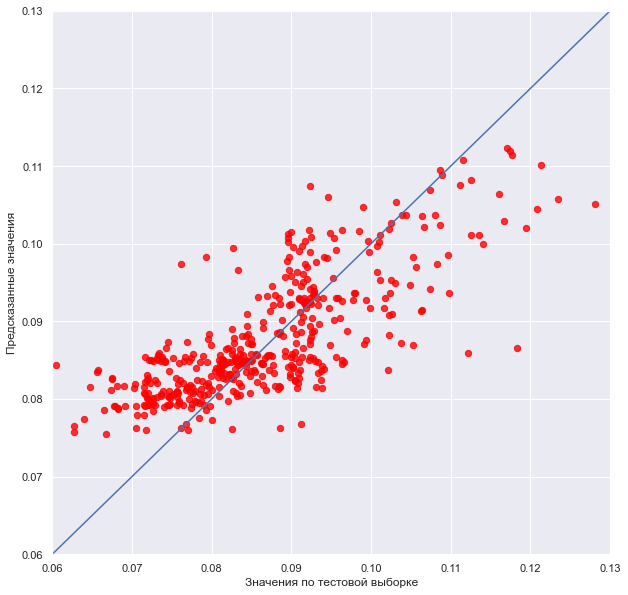

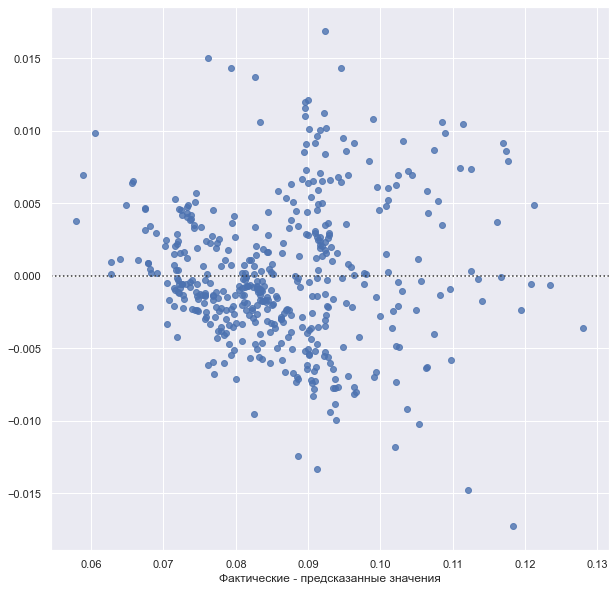

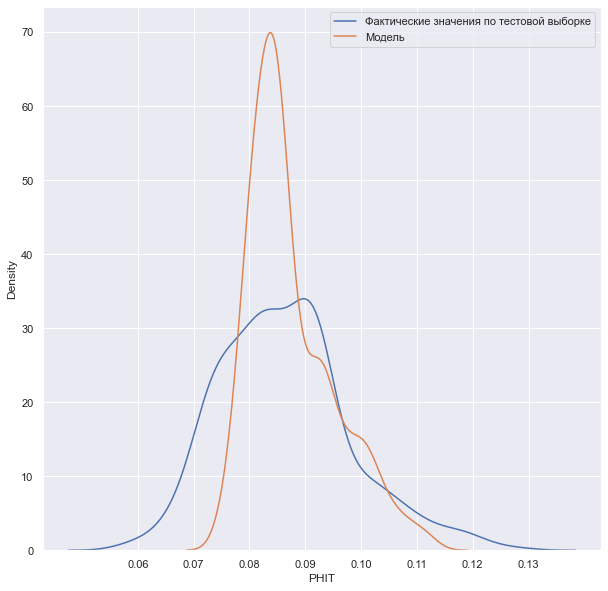

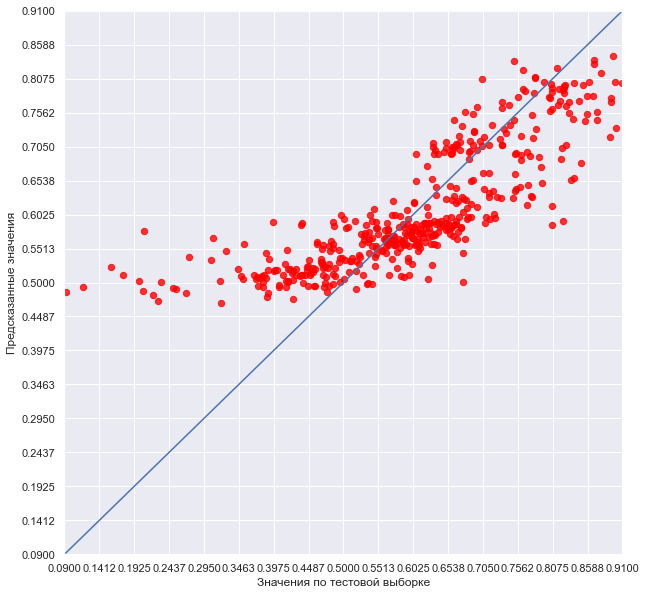

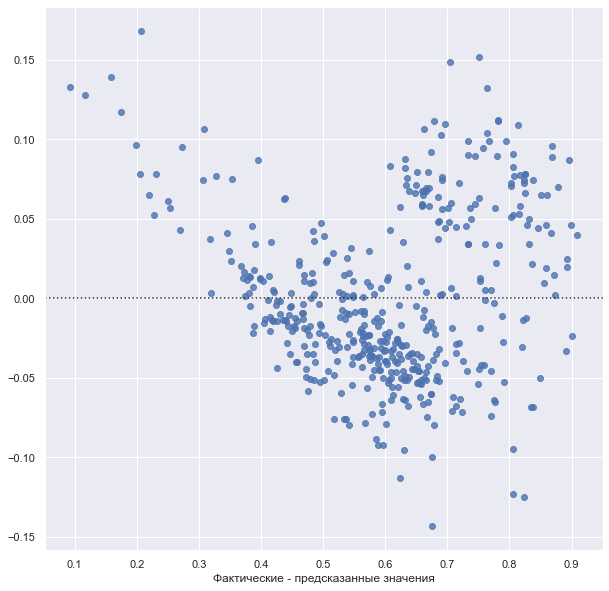

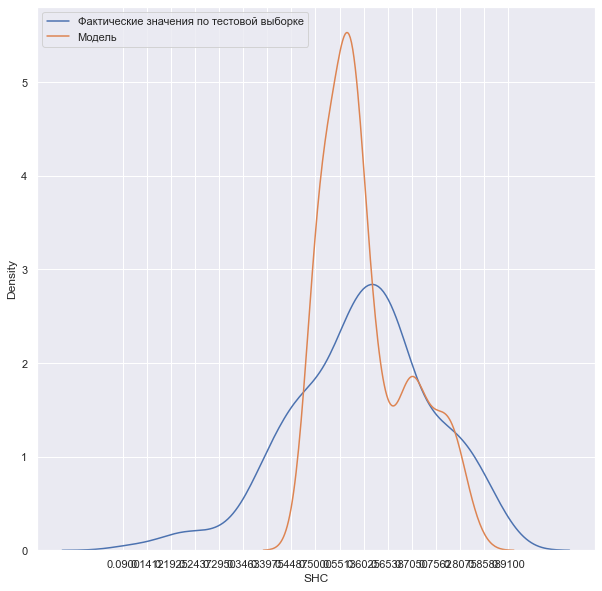

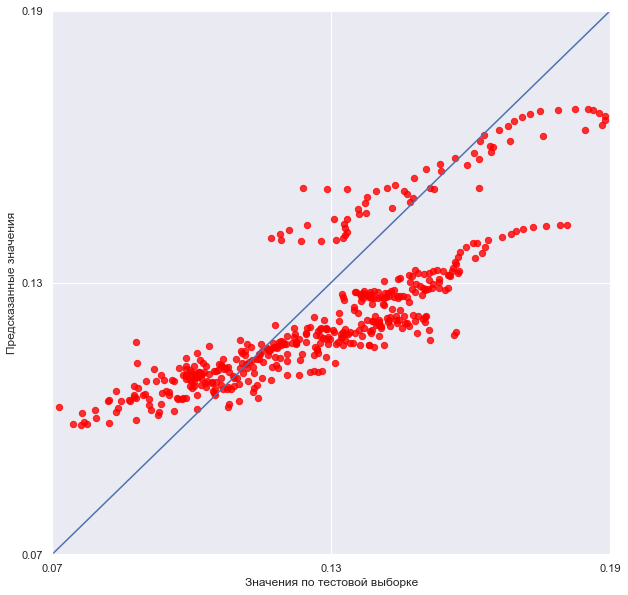

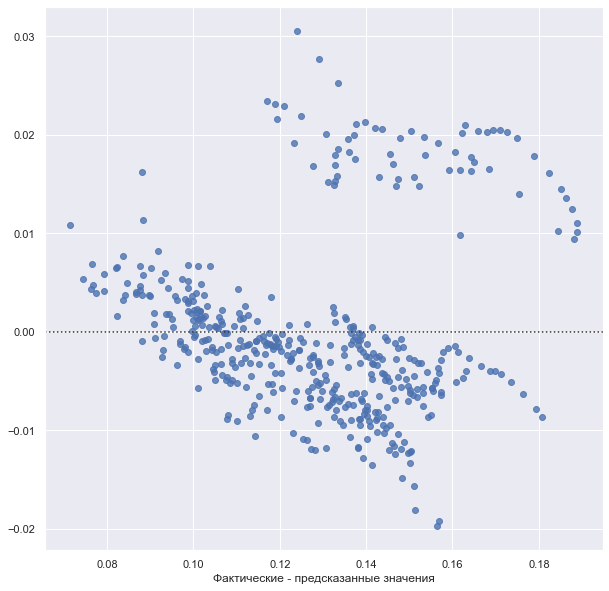

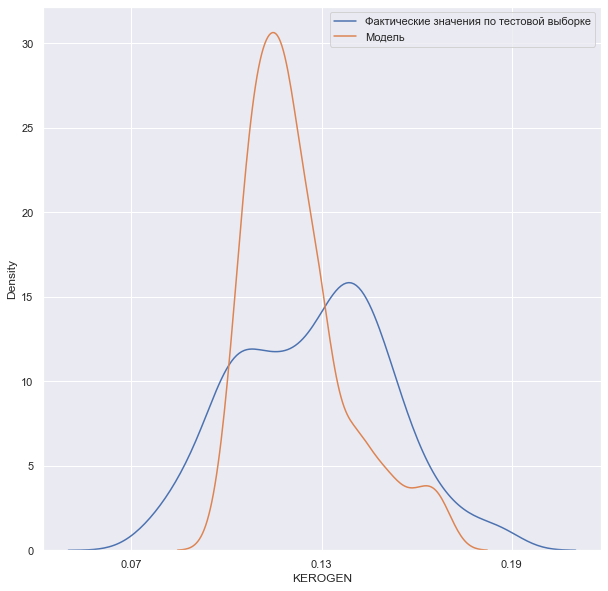

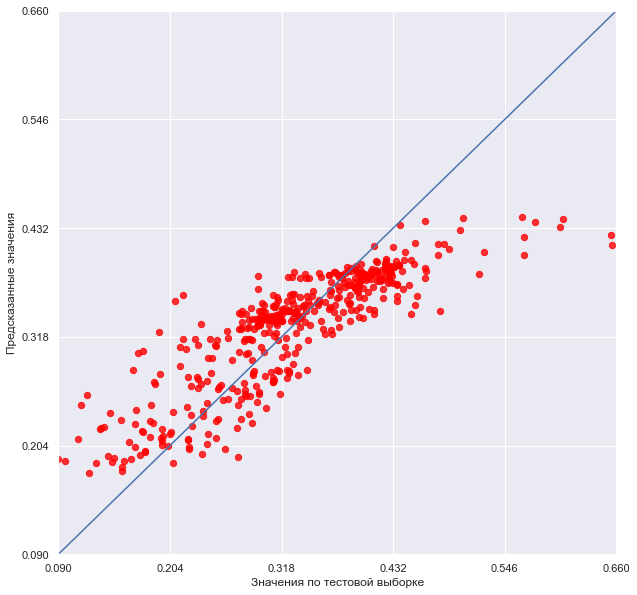

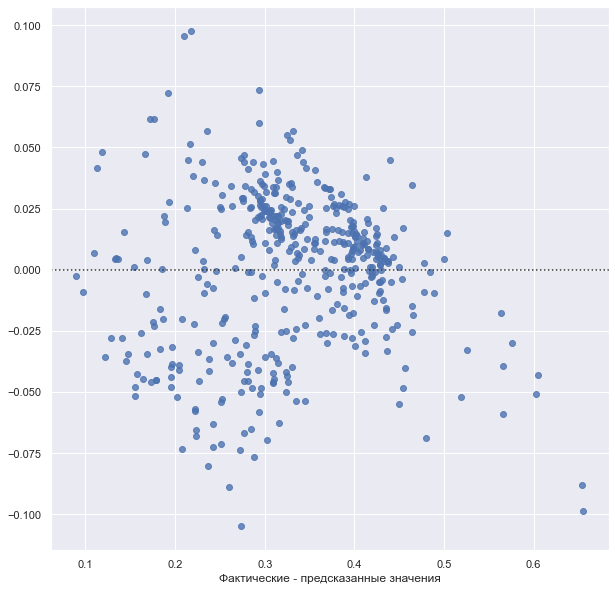

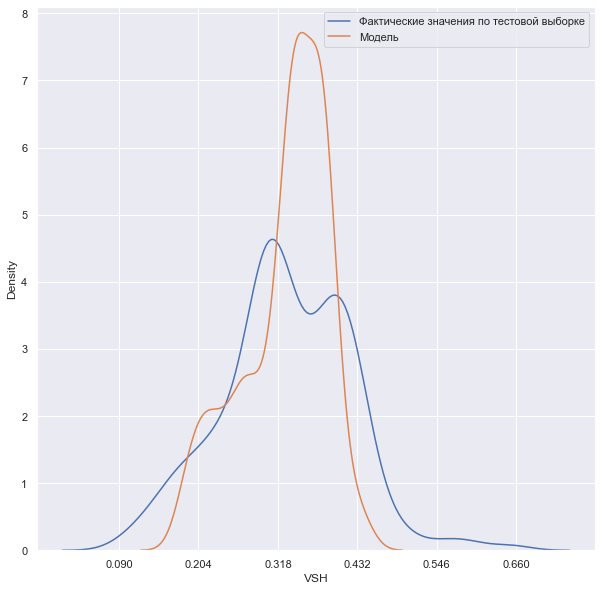

In [22]:
# Рассчитваем метрики качества моделей для прогноза целевых свойств для различных комбинций предикторов

# Перед началом работы меняем название папки для сохраенения результатов в требуемой директории
saving_path = r'C:\Users\user\Documents\ML Пальян\Результаты\UK0'
os.chdir(saving_path)

# Задаем список целевых свойств, для которых будем строить модели
target = [['PHIT'], ['SHC'], ['KEROGEN'], ['VSH']]

# Задаем список целевых зон, для которых будем строить модели
zone = ['V', 'IV', 'III']

# Задаем имя типа модели, который будет отражаться в названиях сохраненных файлов
model_folder = 'Linear'        

# Задаем список скважин для слепого теста
blind_test_wells = ['37R', '32R', '601R', '414R', '22R', '35R', '9426', '42R']

# Задаем варианты комбинаций входных предикторов для тестирования 
#features = [['AI_MOD', 'SI_MOD'],
#            ['AI_MOD', 'SI_MOD', 'PR_MOD'],
#            ['AI_MOD', 'SI_MOD', 'VPVS_MOD'],
#            ['AI_MOD', 'PR_MOD'],
#            ['AI_MOD', 'VPVS_MOD'],
#            ['SI_MOD', 'PR_MOD'],
#            ['SI_MOD', 'VPVS_MOD'],
#            ['AI_MOD', 'SI_MOD', 'PR_MOD', 'RHOB_MOD'],
#            ['AI_MOD', 'SI_MOD', 'VPVS_MOD', 'RHOB_MOD'],
#            ['AI_MOD', 'RT'],
#            ['SI_MOD', 'RT'],
#            ['AI_MOD', 'SI_MOD', 'RT'],
#            ['AI_MOD', 'SI_MOD', 'VPVS_MOD','RT'],
#            ['AI_MOD', 'SI_MOD', 'PR_MOD','RT'],
#            ['AI_MOD', 'SI_MOD', 'RHOB_MOD','RT'],
#            ['AI_MOD', 'SI_MOD', 'VPVS_MOD','RHOB_MOD','RT'],
#            ['AI_MOD', 'SI_MOD', 'PR_MOD','RHOB_MOD','RT'],
#            ['AI_MOD', 'SI_MOD', 'PR_MOD', 'VPVS_MOD','RHOB_MOD','RT'],
#            ]

features = [['AI_MOD', 'SI_MOD', 'RHOB_MOD', 'RT']]

# Задаем число частей для кросс-валидации
fold = 10

# Задаем цену деления для визуализации графиков
unit_tick = {'PHIT': 0.01,
             'SHC': 0.05,
             'KEROGEN':0.05,
             'VSH': 0.1}

# Расчитваем многокомпонентную линейную модель для всего диапазона целевых свойств и комбинаций предикторов
for g in target:
    with open('{mf}_{t}.csv'.format(mf = model_folder, t = g[0]), 'w') as f:
        f.write('Model,Min test,Min predicted,Max test,Max predicted,R2,P,MSE,Test Size\n')
        for i in features:
            model_features = list(map(str, i))
            model_name = '{mf}_{t}_'.format(mf = model_folder, t = g[0]) + '_'.join(model_features)
            fig1, fig2, fig3, Min_predicted, Min_test, Max_predicted, Max_test, R2, P, MSE, Test_size = linear_regression(df_clean_smooth, i, g, fold, zone, blind_test_wells, unit_tick[g[0]])
            f.write('{model},:,{min_pred},{min_test},{max_pred},{max_test},{r2},{p},{mse},{ts}\n'.format(model = model_name,
                                                                                                       min_pred = Min_test,
                                                                                                       min_test = Min_predicted, 
                                                                                                       max_pred = Max_test,
                                                                                                       max_test = Max_predicted,
                                                                                                       r2 = R2,
                                                                                                       p = P,
                                                                                                       mse = MSE,
                                                                                                       ts = Test_size))
            fig1.savefig(r'{mf}\{f}\Xplot_{m}.jpeg'.format(mf = model_folder, f = g[0], m = model_name))
            fig2.savefig(r'{mf}\{f}\'Residual_{m}.jpeg'.format(mf = model_folder, f = g[0], m = model_name))
            fig3.savefig(r'{mf}\{f}\'Dist_{m}.jpeg'.format(mf = model_folder, f = g[0], m = model_name))

## 5. ЗАДАНИЕ ФУНКЦИИ И АНАЛИЗ КАЧЕСТВА МОДЕЛЕЙ С ИСПОЛЬЗОВАНИЕМ МНОГОМЕРНОЙ ПОЛИНОМИАЛЬНОЙ РЕГРЕСИИ

In [ ]:
def poly (df_in, features, target, fold, deg, zone, blind_test_wells, unit_tick):
    # Provide features list, for example ['AI', 'VPVS', 'SI']
    # Target as curve name - for example 'PHI'
    # Unit tick - increment of units for plotting
    # Zoneы as a list
    # Blind test wells as a list
    
    # Создаем список столбцов для дальнейшего использования, который включает набо предикторов, целевую переменную, а также дополнительно скважину и зону.
    extended_features = features + target
    extended_features.extend(['WELL', 'ZONE'])
    df_b1_set = df_in[extended_features]
    
    # Убираем из обучивающей базы данных скважины для слепого теста
    df_b1_well = df_b1_set[(~df_b1_set['WELL'].isin(blind_test_wells))]
    
    # Оставляем в обучивающей базе данных скважины для конкретной зоны
    df_b1 = df_b1_well[(df_b1_well['ZONE'].isin(zone))]
    
    # Убираем из базы данных неопределенные значения
    df_b1.dropna(axis = 0, inplace = True)
    

    X_train = df_b1[features]
    Z_train = df_b1[target]
    
    # Создаем объект Pipeline для полиномиальной модели
    Input = [('polynomial', PolynomialFeatures(degree = deg)), ('model',LinearRegression())]
    pipe=Pipeline(Input)
    
    # Задаем данные для обучения многомерной линейной модели, создаем объект линейной модели и рассчитываем параметры модели с использованием кросс-валидации
    scores = cross_validate(pipe, X_train, Z_train, cv=fold, scoring='r2', return_train_score=True, return_estimator=True)

    # Полученные по кросс-валидации параметры модели осредняем и получаем итоговую модель (Bagging)
    b0 = []
    b1 = []
    for i in range(0,len(target)):
        b0.append(scores['estimator'][i]['model'].intercept_)
        b1.append(scores['estimator'][i]['model'].coef_[0])
    
    numbers = list(range(1,len(b1[0])+1))
    col = list(map(lambda i: 'Var' + str(i), numbers))

    df_intercept =  pd.DataFrame(data = b0, columns = ['b0'])
    df_coeff = pd.DataFrame(data = b1, columns = col)

    b0_fin = df_intercept['b0'].mean()
    b1_fin = []

    for i in range(0,len(b1[0])):
        name = 'Var' + str(i+1)
        b1_fin.append(df_coeff[name].mean())
        
    b1_fin_np = np.asarray(b1_fin).reshape(-1,1)
    
    poly = PolynomialFeatures(degree = deg)
    
    # Начинаем контроль качества модели. Оставляем в тестовой выборке скважины для слепого теста
    df_b2_well = df_b1_set[(df_b1_set['WELL'].isin(blind_test_wells))]
    
    # Оставляем в базе данных для тестирования данные для конкретной зоны
    df_b2 = df_b2_well[(df_b2_well['ZONE'].isin(zone))]
    
    # Убираем из базы данных неопределенные значения
    df_b2.dropna(axis = 0, inplace = True)
    
    
    # Рассчитываем прогнозное значение свойства по модели
    X_test = df_b2[features]
    Z_test = df_b2[target]
    
    X_test_tr = poly.fit_transform(X_test.to_numpy())
    b1_np = np.array(b1).reshape(-1,1)
 
    Z_hat = np.matmul(X_test_tr, b1_fin_np).flatten() + b0_fin
    Z_tr = Z_test[target[0]].to_numpy()

    # Рассчитывем коэффициенты корреляции и среднюю квадратическую ошибку
    R2, P = pearsonr(Z_hat, Z_tr)
    MSE = mean_squared_error(Z_hat, Z_tr)
    
    
    # Строим график Y_истинное - Y_предсказанное
    fig1 = plt.figure(figsize = (10.0,10.0))
    visual_min = round(Z_tr.min(),2)
    visual_max = round(Z_tr.max(),2)
    sns.set(font="Arial")
    equals = np.linspace(visual_min, visual_max, int((visual_max - visual_min)/unit_tick))
    ax1 = sns.regplot(x = Z_tr, y = Z_hat, fit_reg=False, color = 'red', scatter_kws={'s':40})
    ax1 = sns.lineplot(x = equals, y = equals)
    ax1.set(xlabel = 'Значения по тестовой выборке', ylabel = 'Предсказанные значения', xlim = (visual_min, visual_max), ylim = (visual_min, visual_max))
    ax1.set(xticks = (np.linspace(visual_min,visual_max, int((visual_max - visual_min)/unit_tick+1))), 
            yticks = np.linspace(visual_min,visual_max, int((visual_max - visual_min)/unit_tick+1))) 
    ax1.grid(b=True, which='major')
    
    
    # Строим график распределения ошибок
    fig2 = plt.figure(figsize = (10.0,10.0))
    ax2 = sns.residplot(Z_tr,Z_hat)
    ax2.set(xlabel = 'Фактические - предсказанные значения')
    
    
    # Строим гистограммы распределения истинных значений и предсказанного значения свойств
    fig3 = plt.figure(figsize = (10.0,10.0))
    ax3 = sns.distplot(Z_tr, hist=False)
    ax3 = sns.distplot(Z_hat, hist=False)
    ax3.legend(['Фактические значения по тестовой выборке', 'Модель'])
    ax3.set(xlabel = target[0])
    ax3.set(xticks = (np.linspace(visual_min,visual_max, int((visual_max - visual_min)/unit_tick+1))))
    
    return fig1, fig2, fig3, round(Z_hat.min(),3), round(Z_tr.min(),3), round(Z_hat.max(),3), round(Z_tr.max(),3), round(R2,3), P, MSE, round(len(Z_tr),3)

In [ ]:
# Рассчитваем метрики качества моделей для прогноза целевых свойств для различных комбинций предикторов

# Перед началом работы меняем название папки для сохраенения результатов в требуемой директории
saving_path = r'C:\Users\user\Documents\ML Пальян\Результаты\UK1'
os.chdir(saving_path)

# Задаем список целевых свойств, для которых будем строить модели
target = [['PHIT'], ['SHC'], ['KEROGEN'], ['VSH']]

# Задаем список целевых зон, для которых будем строить модели
zone = ['UK1']

# Задаем имя типа модели, который будет отражаться в названиях сохраненных файлов
model_folder = 'Poly2'        

# Задаем список скважин для слепого теста
blind_test_wells = ['203_p','238_p']

# Задаем варианты комбинаций входных предикторов для тестирования
features = [['AI_MOD', 'SI_MOD'],
            ['AI_MOD', 'SI_MOD', 'PR_MOD'],
            ['AI_MOD', 'SI_MOD', 'VPVS_MOD'],
            ['AI_MOD', 'PR_MOD'],
            ['AI_MOD', 'VPVS_MOD'],
            ['SI_MOD', 'PR_MOD'],
            ['SI_MOD', 'VPVS_MOD'],
            ['AI_MOD', 'SI_MOD', 'PR_MOD', 'RHOB_MOD'],
            ['AI_MOD', 'SI_MOD', 'VPVS_MOD', 'RHOB_MOD'],
            ['AI_MOD', 'RT'],
            ['SI_MOD', 'RT'],
            ['AI_MOD', 'SI_MOD', 'RT'],
            ['AI_MOD', 'SI_MOD', 'VPVS_MOD','RT'],
            ['AI_MOD', 'SI_MOD', 'PR_MOD','RT'],
            ['AI_MOD', 'SI_MOD', 'RHOB_MOD','RT'],
            ['AI_MOD', 'SI_MOD', 'VPVS_MOD','RHOB_MOD','RT'],
            ['AI_MOD', 'SI_MOD', 'PR_MOD','RHOB_MOD','RT'],
            ['AI_MOD', 'SI_MOD', 'PR_MOD', 'VPVS_MOD','RHOB_MOD','RT'],
            ]

# Задаем число частей для кросс-валидации
fold = 10

# Задаем цену деления для визуализации графиков
unit_tick = {'PHIT': 0.01,
             'SHC': 0.05,
             'KEROGEN':0.05,
             'VSH': 0.1}

# Задаем степень полиномальной модели
deg = 2

# Расчитваем многокомпонентную полиномиальную модель для всего диапазона целевых свойств и комбинаций предикторов
for g in target:
    with open('{mf}_{t}.csv'.format(mf = model_folder, t = g[0]), 'w') as f:
        f.write('Model,Min test,Min predicted,Max test,Max predicted,R2,P,MSE,Test Size\n')
        for i in features:
            model_features = list(map(str, i))
            model_name = '{mf}_{t}_'.format(mf = model_folder, t = g[0]) + '_'.join(model_features)
            fig1, fig2, fig3, Min_predicted, Min_test, Max_predicted, Max_test, R2, P, MSE, Test_size = poly(df_clean, i, g, fold, deg, zone, blind_test_wells, unit_tick[g[0]])
            f.write('{model},:,{min_pred},{min_test},{max_pred},{max_test},{r2},{p},{mse},{ts}\n'.format(model = model_name,
                                                                                                       min_pred = Min_test,
                                                                                                       min_test = Min_predicted, 
                                                                                                       max_pred = Max_test,
                                                                                                       max_test = Max_predicted,
                                                                                                       r2 = R2,
                                                                                                       p = P,
                                                                                                       mse = MSE,
                                                                                                       ts = Test_size))
            fig1.savefig(r'{mf}\{f}\Xplot_{m}.jpeg'.format(mf = model_folder, f = g[0], m = model_name))
            fig2.savefig(r'{mf}\{f}\'Residual_{m}.jpeg'.format(mf = model_folder, f = g[0], m = model_name))
            fig3.savefig(r'{mf}\{f}\'Dist_{m}.jpeg'.format(mf = model_folder, f = g[0], m = model_name))

In [ ]:
file_list = [f for f in glob.glob('*.csv')]


with open('Aggregated_stat Upper.csv', 'w') as file_out:
    file_out.write('Model,Min test,Min predicted,Max test,Max predicted,R2,P,MSE,Test Size,Alpha\n')
    for i in file_list:
        f = open(i, 'r')
        counter = -1
        for line in f:
            counter +=1
            if counter == 0:
                continue
            else:
                line.split("_")
                file_out.write(line)

## 6. СРАВНЕНИЕ ДИНАМИЧЕСКИХ ДИАПАЗОНОВ ПО СРР, ЭРР И СКВАЖИННЫМ ДАННЫМ

In [ ]:
data_path = r'C:\Users\user\Documents\ML Пальян\Trends'
os.chdir(data_path)

df_AI = pd.read_csv('AI.csv', sep = ';')
df_AI['Bin'] = df_AI['Bin']/1000


df_SI = pd.read_csv('SI.csv', sep = ';')
df_SI['Bin'] = df_SI['Bin']/1000


df_PR = pd.read_csv('PR.csv', sep = ';')
df_VPVS = pd.read_csv('VPVS.csv', sep = ';')
df_RHOB = pd.read_csv('RHOB.csv', sep = ';')
df_RT = pd.read_csv('RT.csv', sep = ';')

df_test_clean_smooth = df_clean_smooth[['AI_MOD', 'SI_MOD', 'VPVS_MOD', 'PR_MOD', 'RHOB_MOD', 'RT']]
df_test_clean_smooth.dropna(axis = 0, inplace = True)

df_VPVS.head(20)

In [ ]:
def dynamic_range_check(df_seismic, df_wl):
    """Функция для построения графиков динамических диапазонов парамеров по СРР/ЭРР и скважинным данным"""
    fig1 = plt.figure(figsize = (10.0,10.0))
    ax1 = plt.bar(x = df_seismic['Bin'], height = df_seismic['Value']/100, width = (df_seismic.loc[1,'Bin']-df_seismic.loc[0,'Bin']))
    ax2 = sns.histplot(data = df_wl, bins = df_seismic['Bin'], color = 'red', stat = 'probability', fill = False)
    ax2.legend(['Инверсия', 'ГИС'])
    
    return fig1

In [ ]:
df_seismic_all = [df_AI, df_SI, df_VPVS, df_RHOB, df_PR, df_RT]
df_wll_all = [df_test_clean_smooth['AI_MOD'], 
              df_test_clean_smooth['SI_MOD'], 
              df_test_clean_smooth['VPVS_MOD'], 
              df_test_clean_smooth['RHOB_MOD'], 
              df_test_clean_smooth['PR_MOD'],
              df_test_clean_smooth['RT']
             ]

for i,j in zip(df_seismic_all, df_wll_all):
    dynamic_range_check(i,j)

In [ ]:
fig1 = plt.figure(figsize = (10.0,10.0))
ax1 = plt.bar(x = df_VPVS['Bin'], height = df_VPVS['Value']/100, width = 0.05)
ax2 = sns.histplot(data = df_test_clean_smooth['VPVS_MOD'], bins = df_VPVS['Bin'], color = 'red', stat = 'density', fill = False)

In [ ]:
zones_plot = ['V', 'IV', 'III', 'II', 'I']
rock_plot=['НПП', 'ТП', 'ППИ', 'ТСП2']


def lith_code(lith_dict, df, name1, name2):
    # df - dataframe where conversion is needed
    # name 1 - df column where codes are contained
    # name 2 - new df column name where lithology/rock type flag will be contained
    for i in lith_dict.keys():
        for j in range(0, df.shape[0]):
            if df.loc[j, name1] == i:
                df.at[j, name2] = lith_dict[i]
            else:
                continue

RT_dict = {0:'НПП', 1:'ТСП2', 2:'ТП', 3:'ППИ'}                
lith_code(RT_dict, df_clean_b, 'LITHOLOGY', 'LITHOLOGY_NAME')

for i in zones_plot:
    plt.figure(figsize = (15.0, 15.0))
    df_plot = df_clean_b[(df_clean_b['ZONE'] == i)]
    sns.histplot(data = df_plot, x = 'PHIT', hue = 'LITHOLOGY_NAME', element = 'poly', stat = 'probability')
    plt.xlim(0,2)

In [29]:
df_clean_b.head()

,level_0,index,AI_MOD,BI_RR_MOD_INTERP_BAZH_CCE,BITUMEN,CBW,CLAY,CQ_FLAG,E_MOD,EQ_FLAG,...,TOC,VP_MOD,VPVS_MOD,VS_MOD,VSH,WATER,WELL,ZONE,MD,LITHOLOGY_NAME
0,0,24647,6.8933,0.2685,0.0333,0.0389,0.3503,1.0,14.8212,1.0,...,0.0728,2797.0454,1.8300,1528.4554,0.3892,0.0,130_p,V,2465.3,НПП
1,1,24648,6.8945,0.2648,0.0330,0.0394,0.3544,1.0,14.7395,1.0,...,0.0726,2791.0654,1.8343,1521.6315,0.3938,0.0,130_p,V,2465.4,НПП
2,2,24649,6.8650,0.2596,0.0319,0.0407,0.3661,1.0,14.5561,1.0,...,0.0710,2777.0310,1.8381,1510.8357,0.4068,0.0,130_p,V,2465.5,НПП
3,3,24650,6.8150,0.2550,0.0303,0.0424,0.3812,1.0,14.3393,1.0,...,0.0689,2760.1501,1.8400,1500.0941,0.4236,0.0,130_p,V,2465.6,НПП
4,4,24651,6.7717,0.2521,0.0293,0.0434,0.3910,1.0,14.1758,0.0,...,0.0679,2746.9905,1.8404,1492.6392,0.4344,0.0,130_p,V,2465.7,НПП


In [62]:
def gaussianNB(df_in, features, target, fold, zone, blind_test_wells, model_name):
    # Provide features list, for example ['AI', 'VPVS', 'SI']
    # Target as curve name - for example 'PHI'
    # Unit tick - increment of units for plotting
    # Zoneы as a list
    # Blind test wells as a list
    
    
    # Создаем список столбцов для дальнейшего использования, который включает набо предикторов, целевую переменную, а также дополнительно скважину и зону.
    extended_features = features + target
    extended_features.extend(['WELL', 'ZONE'])
    df_b1_set = df_in[extended_features]
    
    # Убираем из обучивающей базы данных скважины для слепого теста
    df_b1_well = df_b1_set[(~df_b1_set['WELL'].isin(blind_test_wells))]
    
    # Оставляем в обучивающей базе данных скважины для конкретной зоны
    df_b1 = df_b1_well[(df_b1_well['ZONE'].isin(zone))]
    
    # Убираем из базы данных неопределенные значения
    df_b1.dropna(axis = 0, inplace = True)

    X_train = df_b1[features]
    Z_train = df_b1[target]
    
    # Начинаем контроль качества модели. Оставляем в тестовой выборке скважины для слепого теста
    df_b2_well = df_b1_set[(df_b1_set['WELL'].isin(blind_test_wells))]
    
    # Оставляем в базе данных для тестирования данные для конкретной зоны
    df_b2 = df_b2_well[(df_b2_well['ZONE'].isin(zone))]
    
    # Убираем из базы данных неопределенные значения
    df_b2.dropna(axis = 0, inplace = True)
    
    # Рассчитываем прогнозное значение свойства по модели
    X_test = df_b2[features]
    Z_test = df_b2[target]
    gnb = GaussianNB()
    Z_hat = gnb.fit(X_train, Z_train).predict(X_test)
    
    accuracy = round(gnb.score(X_test, Z_test),3)  

    
    print ('Mean accuracy:{a}\n'.format(a = accuracy))
    
    return accuracy

In [65]:
# Рассчитваем метрики качества моделей для прогноза целевых свойств для различных комбинций предикторов

# Перед началом работы меняем название папки для сохраенения результатов в требуемой директории
saving_path = r'C:\Users\user\Documents\ML Пальян\Результаты\Upper'
os.chdir(saving_path)

# Задаем список целевых свойств, для которых будем строить модели
target = ['LITHOLOGY']

# Задаем список целевых зон, для которых будем строить модели
zone = ['V', 'IV', 'III', 'II', 'I']      

# Задаем список скважин для слепого теста
blind_test_wells = ['37R', '32R', '601R', '414R', '22R', '35R', '9426', '42R']

# Задаем варианты комбинаций входных предикторов для тестирования
features = [['AI_MOD', 'SI_MOD'],
            ['AI_MOD', 'SI_MOD', 'PR_MOD'],
            ['AI_MOD', 'SI_MOD', 'VPVS_MOD'],
            ['AI_MOD', 'SI_MOD', 'RHOB_MOD'],
            ['AI_MOD', 'PR_MOD'],
            ['AI_MOD', 'VPVS_MOD'],
            ['SI_MOD', 'PR_MOD'],
            ['SI_MOD', 'VPVS_MOD'],
            ['AI_MOD', 'SI_MOD', 'PR_MOD', 'RHOB_MOD'],
            ['AI_MOD', 'SI_MOD', 'VPVS_MOD', 'RHOB_MOD']
           ]


# Задаем число частей для кросс-валидации
fold = 10

with open('NB models.csv', 'w') as f:
    f.write('Model,Recall,Precision,F1-score,Accuracy\n')
    for i in features:
        model_features = list(map(str, i))
        model_name = 'NB_' + '_'.join(model_features)
        accuracy = gaussianNB(df_clean, i, target, fold, zone, blind_test_wells, model_name)
        f.write('{m},{a}\n'.format(m = model_name, a = accuracy))

Mean accuracy:0.484

Mean accuracy:0.711

Mean accuracy:0.713

Mean accuracy:0.602

Mean accuracy:0.716

Mean accuracy:0.714

Mean accuracy:0.743

Mean accuracy:0.741

Mean accuracy:0.688

Mean accuracy:0.688



In [54]:
df_clean.head()

,AI_MOD,BI_RR_MOD_INTERP_BAZH_CCE,BITUMEN,CBW,CLAY,CQ_FLAG,E_MOD,EQ_FLAG,G_MOD,GR,...,TNPH,TOC,VP_MOD,VPVS_MOD,VS_MOD,VSH,WATER,WELL,ZONE,MD
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130_p,N/A,0.6
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130_p,N/A,0.7
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130_p,N/A,0.8
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130_p,N/A,0.9
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130_p,N/A,1.0
